# Graph-Sparse Logistic Regression applied to the real proteomics data from the TCGA/CPTAC Ovarian Cancer dataset. 

In [1]:
%pylab inline

import sys
import pickle
import pandas as pd
import networkx as nx

from sklearn.preprocessing import LabelEncoder

from matplotlib_venn import venn3, venn3_circles, venn2

repo_path = '/Users/alex/Documents/gslr/'
interactome_path = repo_path + 'experiments/algorithms/pcsf/inbiomap_temp.tsv'

sys.path.append(repo_path + 'gslr/')
import gslr

Populating the interactive namespace from numpy and matplotlib


### i. Load Datasets

In [2]:
medullo = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/medullo_inbiomap_exp.tsv', index_col=0)
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)
brca = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/brca_inbiomap_exp.tsv', index_col=0)

medullo_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/medullo_labels.csv', index_col=0)
ovarian_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/ovarian_labels.csv', index_col=0)
brca_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/brca_labels.csv', index_col=0)

### ii. Load Interactome

In [3]:
inbiomap_experimentally = pd.read_csv(interactome_path, sep='\t', names=['protein1','protein2','cost'])
inbiomap_experimentally.head()

,protein1,protein2,cost
0,ZNF91,NDEL1,1.253
1,ZNF91,ELAVL1,1.254
2,ZNF91,SUMO1,1.245
3,ZNF91,SUMO3,1.245
4,ZNF91,CHMP5,1.241


In [4]:
(edges, nodes) = pd.factorize(inbiomap_experimentally[["protein1","protein2"]].unstack())
edges = edges.reshape(inbiomap_experimentally[["protein1","protein2"]].shape, order='F')
edges

array([[    0,  1228],
       [    0,  1279],
       [    0,  4071],
       ..., 
       [14190, 14237],
       [14191, 14378],
       [14192, 14539]])

## I. TCGA Ovarian

In [5]:
dataset = ovarian.copy()
labels = ovarian_labels.copy()
dataset.shape, labels.shape

((206, 16349), (206, 1))

### i. Prepare Dataset

In [6]:
dataset = dataset.transpose().reindex(index=nodes).transpose()
X = dataset.values
dataset.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
PNNL-TCGA-09-1664,0.0,0.000,0.0000,0.0,0.279,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1484,0.0,0.175,0.0000,0.0,0.000,0.0,-0.443,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1488,0.0,0.000,0.0000,0.0,-0.462,0.0,0.621,0.0,0.0,-0.398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1489,0.0,0.000,-0.2670,0.0,0.000,0.0,-0.601,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1494,0.0,0.000,0.0117,0.0,0.053,0.0,-1.260,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
labels = labels.values.flatten().tolist()

In [8]:
labeler = LabelEncoder()
labeler.fit(labels)
y = labeler.transform(labels)
y

array([0, 1, 2, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 0, 3, 2, 4, 4, 0, 0,
       0, 2, 2, 4, 0, 0, 4, 3, 0, 0, 3, 3, 2, 0, 1, 2, 1, 3, 5, 4, 2, 0, 4,
       2, 4, 2, 0, 4, 0, 1, 2, 3, 3, 0, 4, 3, 3, 0, 2, 2, 2, 0, 1, 2, 4, 2,
       1, 1, 2, 0, 3, 3, 1, 0, 0, 2, 1, 0, 5, 0, 2, 0, 5, 1, 3, 2, 2, 2, 2,
       2, 2, 0, 3, 2, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 3, 3, 2, 0, 0, 2, 2, 0,
       2, 1, 0, 4, 5, 3, 0, 0, 0, 3, 2, 5, 1, 1, 0, 3, 0, 1, 2, 1, 0, 3, 0,
       0, 0, 4, 0, 4, 2, 0, 4, 0, 1, 4, 0, 1, 0, 2, 0, 3, 2, 3, 2, 2, 0, 3,
       0, 2, 4, 1, 2, 0, 2, 1, 3, 2, 2, 0, 0, 3, 4, 1, 2, 1, 1, 1, 0, 0, 0,
       1, 3, 0, 0, 4, 0, 3, 0, 1, 3, 1, 3, 0, 0, 1, 0, 1, 0, 1, 3, 1, 4])

### ii. Graph-Sparse Logistic Regression

In [12]:
d = len(nodes)
c = 6

graph_opts = gslr.GraphOptions(edges=edges, root=-1, num_clusters=1, pruning='strong')

sparsity_low = 150
sparsity_high = 350

verbosity_level = 1

num_steps = 25
possible_steps = np.array([0.03, 0.1, 0.3])
steps = np.tile(possible_steps, (num_steps, 1))

W0 = np.zeros((c, d))

In [13]:
W_hat, losses = gslr.gslr(X, y, W0, sparsity_low, sparsity_high, graph_opts, steps, verbosity_level, edge_costs=inbiomap_experimentally.cost.values, edge_costs_multiplier=6)

iteration 1:
  loss_cur = 1.7917594692280547   loss_next = 1.4256852914386093   step_size = 0.03
  loss_cur = 1.7917594692280547   loss_next = 0.95813951350749   step_size = 0.1
  loss_cur = 1.7917594692280547   loss_next = 0.8407761163206704   step_size = 0.3
  best_step_size: 0.3
iteration 2:
  loss_cur = 0.8407761163206704   loss_next = 0.742234938876066   step_size = 0.03
  loss_cur = 0.8407761163206704   loss_next = 0.6400959210765067   step_size = 0.1
  loss_cur = 0.8407761163206704   loss_next = 1.778614247420891   step_size = 0.3
  best_step_size: 0.1
iteration 3:
  loss_cur = 0.6400959210765067   loss_next = 0.60821942037204   step_size = 0.03
  loss_cur = 0.6400959210765067   loss_next = 0.5568396052721837   step_size = 0.1
  loss_cur = 0.6400959210765067   loss_next = 0.7335156968447939   step_size = 0.3
  best_step_size: 0.1
iteration 4:
  loss_cur = 0.5568396052721837   loss_next = 0.5869699061685455   step_size = 0.03
  loss_cur = 0.5568396052721837   loss_next = 0.518323

Train accuracy: 0.9757281553398058


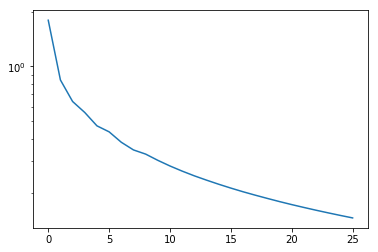

In [14]:
yhat = gslr.predict(X, W_hat)
num_cor = gslr.num_correct(y, yhat)
print('Train accuracy: {}'.format(num_cor / float(len(y))))

plt.plot(losses)
plt.yscale('log')

### iii. Unpack Results

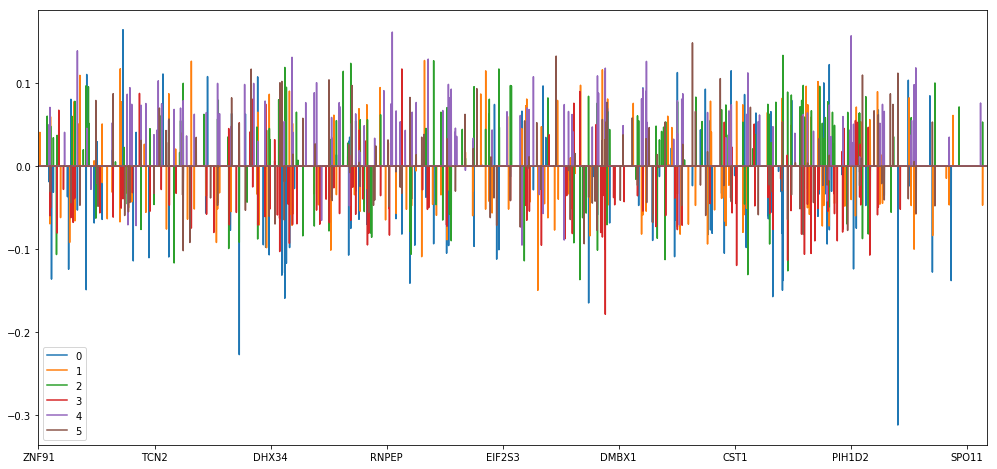

In [15]:
coefs = pd.DataFrame(W_hat, columns=dataset.columns)
coefs.transpose().plot(figsize=(17,8))

In [16]:
features = coefs.columns[(coefs != 0).any()].tolist()
len(features)

592

In [5]:
features

['SLC25A6',
 'MICAL1',
 'LRP1',
 'SERPIND1',
 'DCN',
 'HLA-DRB1',
 'MYH10',
 'PPIC',
 'PLOD1',
 'ECH1',
 'NEFM',
 'PAFAH1B3',
 'AHSG',
 'COTL1',
 'PML',
 'F10',
 'OSBPL10',
 'AOC3',
 'ISLR',
 'FYB',
 'CRYAB',
 'TAGLN3',
 'LCP2',
 'ITGB2',
 'ANXA2',
 'MFAP4',
 'C1QBP',
 'PLSCR1',
 'DAXX',
 'PLAUR',
 'FABP4',
 'CDC25C',
 'ELN',
 'RCN3',
 'ACTBL2',
 'ATP6AP2',
 'CDC42',
 'HMGB2',
 'GSTA1',
 'BPGM',
 'ABI3',
 'ARHGDIB',
 'TARDBP',
 'HLA-B',
 'PLCG1',
 'SERPINA4',
 'TIMP2',
 'ELANE',
 'NEB',
 'CLEC3B',
 'HLA-C',
 'HSPA8',
 'HLA-DMB',
 'ANXA1',
 'SEC23A',
 'CDKN2A',
 'SH3GL2',
 'C8B',
 'ITGA6',
 'HIST2H2BF',
 'GNLY',
 'APOH',
 'CA1',
 'LTBP1',
 'RAC1',
 'TMPO',
 'KRT72',
 'CKM',
 'C7',
 'KRT73',
 'DDX58',
 'C5',
 'MTHFD2',
 'VCAM1',
 'FGB',
 'PPM1G',
 'C9',
 'H1F0',
 'MYOF',
 'GSTM3',
 'COLEC11',
 'CRABP2',
 'TPPP3',
 'MMP2',
 'PCNA',
 'SNCG',
 'NFKB1',
 'SAA2',
 'HSP90AA1',
 'ACTR3',
 'BAG3',
 'MYH11',
 'HERC5',
 'PHF20L1',
 'PDLIM5',
 'TAGLN',
 'NID2',
 'SGCD',
 'ALPP',
 'FCER1G',
 'TTR',


In [17]:
coefs.to_pickle('ovarian_coefs.pickle')